In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import curve_fit 
import geopandas as gpd
import os
import imageio

In [53]:
cases = pd.read_csv('cases_from_no.csv')
cases['Date']=cases['Date'].astype('datetime64[ns]')

In [54]:
all_cases_by_date = cases.groupby('Date').sum().reset_index().sort_values('Date')
cumulative = [all_cases_by_date['Cases'][0]]
for i in range(len(all_cases_by_date['Cases'])-1):
    cumulative.append(cumulative[i]+all_cases_by_date['Cases'][i+1])
all_cases_by_date['Cumulative'] = cumulative

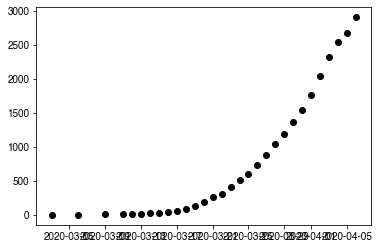

In [55]:
plt.plot((all_cases_by_date['Date']),all_cases_by_date['Cumulative'],'ko')

In [56]:
fp = './NC_Counties.shp'
map_df = gpd.read_file(fp)
map_df['Name']=['Rockingham','Guilford','Alamance','Alexander','Randolph','Wayne','Ashe','Alleghany','Currituck','Camden','Surry',
                'Gates','Hertford','Northhampton','Stokes','Warren','Vance','Granville','Caswell','Person','Pasquotank','Halifax',
                'Wilkes','Watauga','Perquimans','Chowan','Avery','Yadkin','Dare','Forsyth','Franklin','Bertie','Orange','Durham','Nash',
                'Mitchell','Edgecombe','Caldwell','Tyrrell','Yancey','Madison','Martin','Wake','Davie','Washington','Burke','Davidson',
                'McDowell','Chatham','Wilson','Buncombe','Haywood','Catawba','Pitt','Johnston','Swain','Beaufort','Hyde','Greene',
                'Rutherford','Lee','Cleveland','Jackson','Harnett','Graham','Henderson','Moore','Montgomery','Stanly','Transylvannia',
                'Polk','Lenoir','Craven','Macon','Cherokee','Pamlico','Sampson','Cumberland','Clay','Jones','Carteret','Union','Anson',
                'Hoke','Duplin','Richmond','Scotland','Onslow','Robeson','Bladen','Pender','Columbus','New Hanover','Brunswick','Iredell',
                'Rowan','Lincoln','Mecklenburg','Cabarrus','Gaston']


In [57]:
cases_by_county=cases[cases['Date']<=max_date].groupby('County').sum().reset_index()
merged = map_df.set_index('Name').join(cases_by_county.set_index('County')).reset_index()
merged = merged.set_index('Name').join(demographics.set_index('Name')).reset_index()
merged['Per capita'] = merged['Cases']/merged['Population']

In [58]:
demographics = pd.read_csv('county_demo.csv')
demographics.columns

Index(['Name', 'Population', 'Area (sq mi)', 'Per capita income',
       'Median household income', 'Median family income'],
      dtype='object')

/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:84: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:84: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:84: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/sub

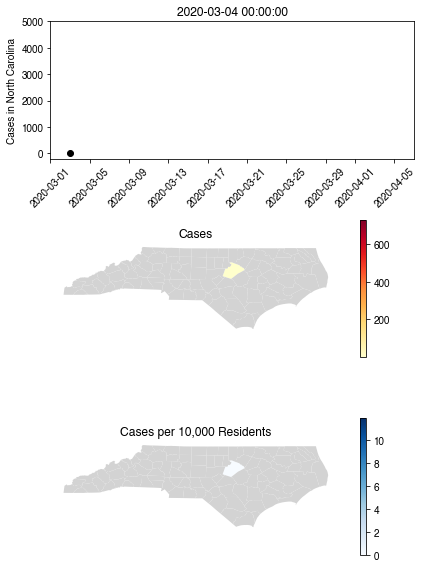

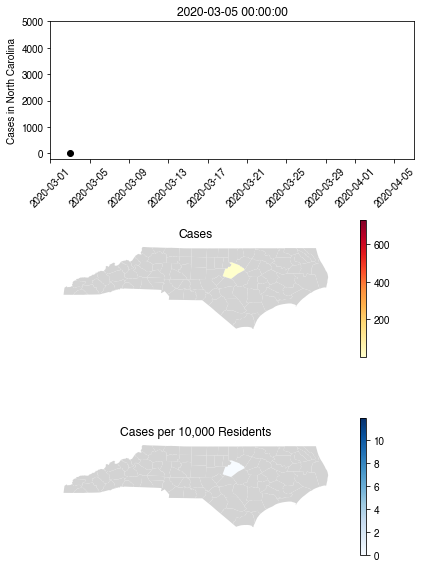

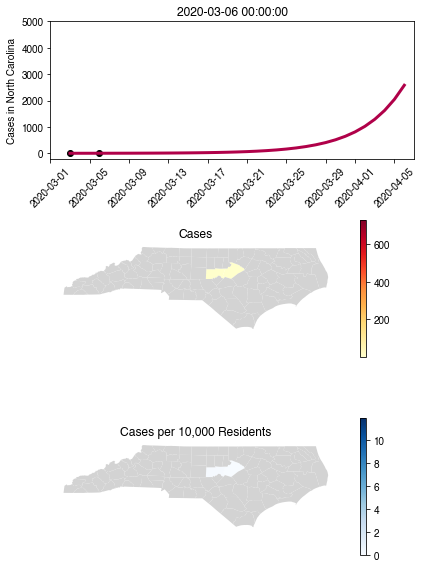

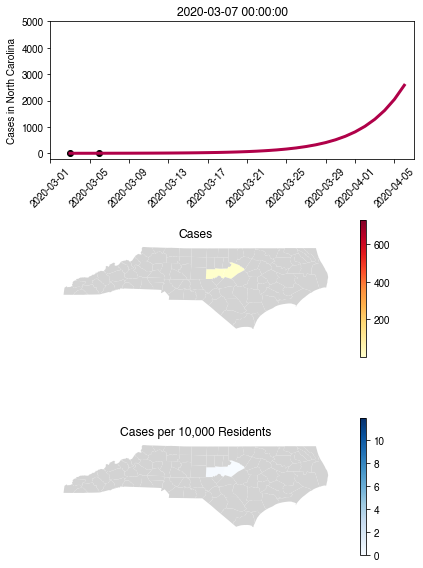

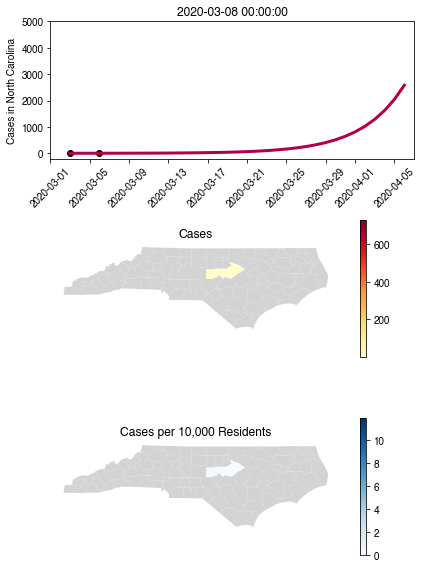

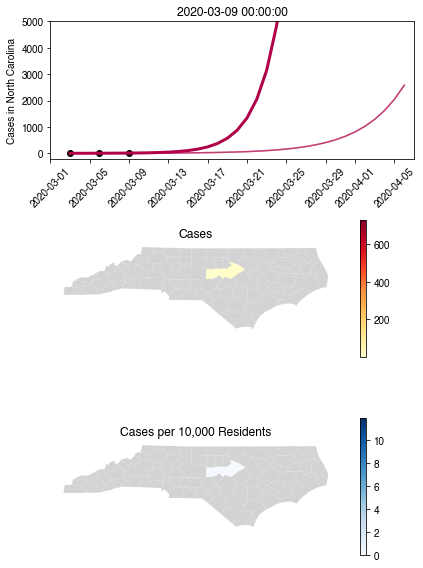

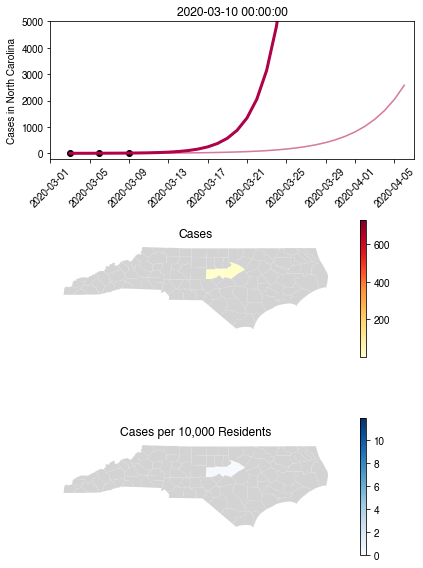

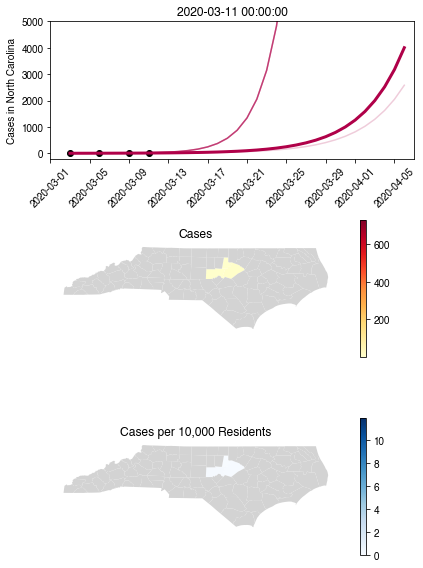

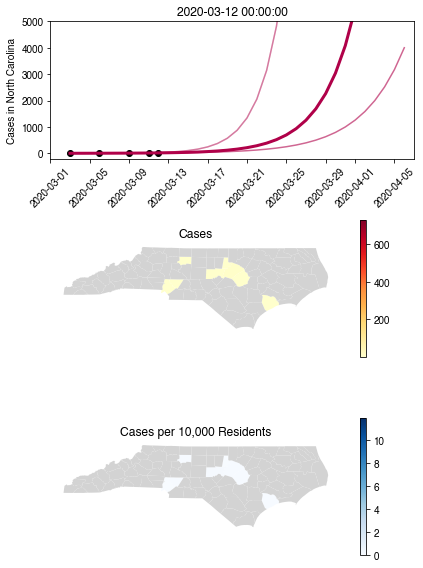

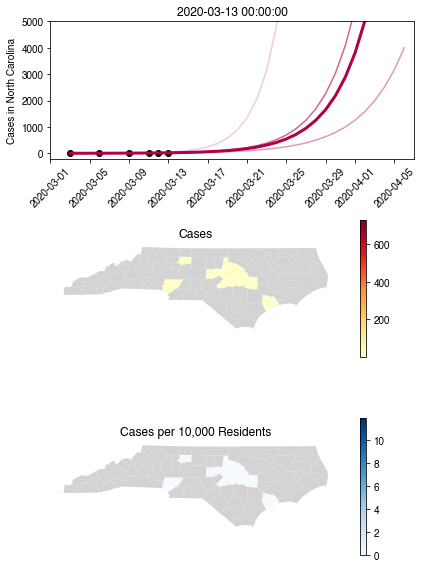

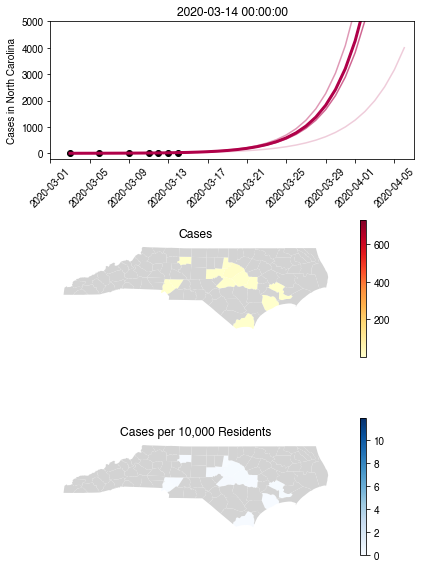

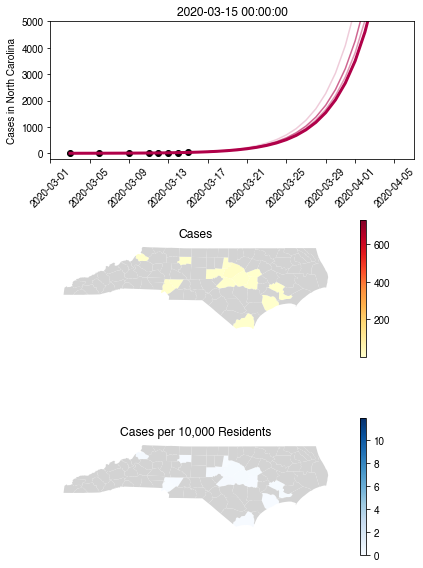

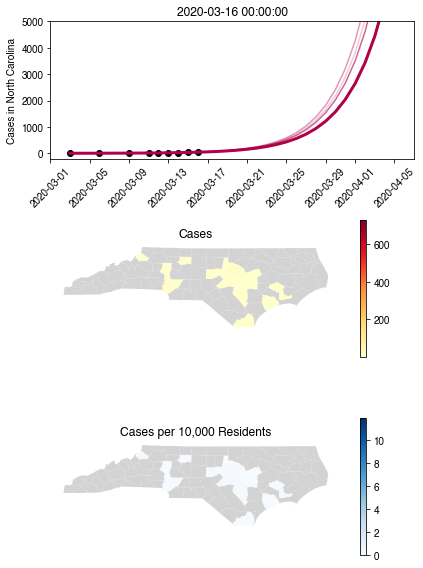

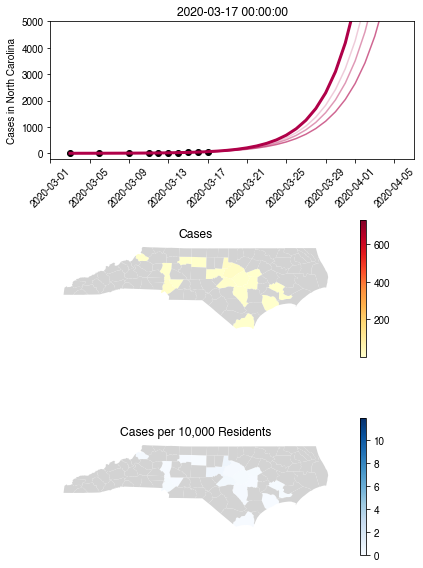

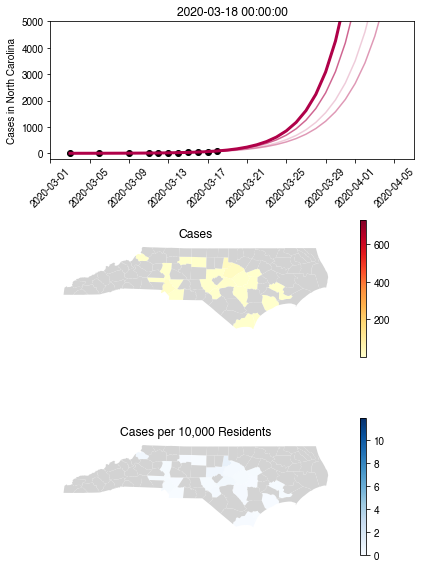

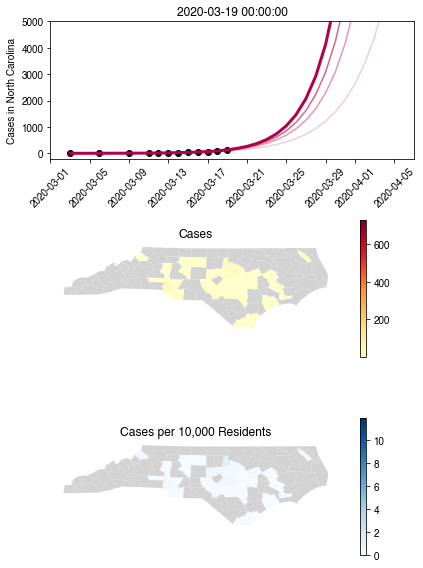

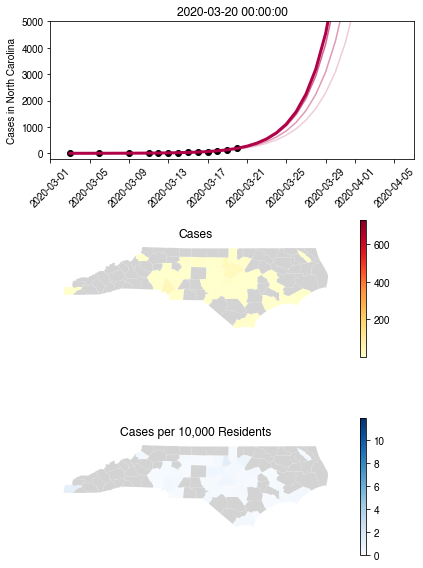

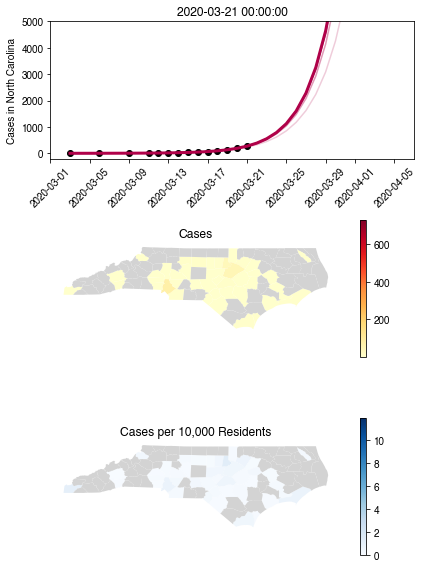

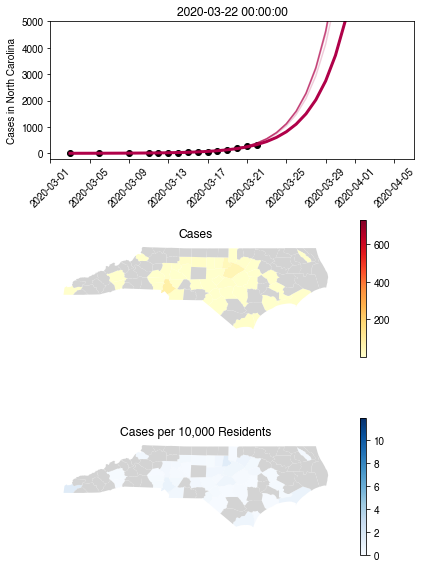

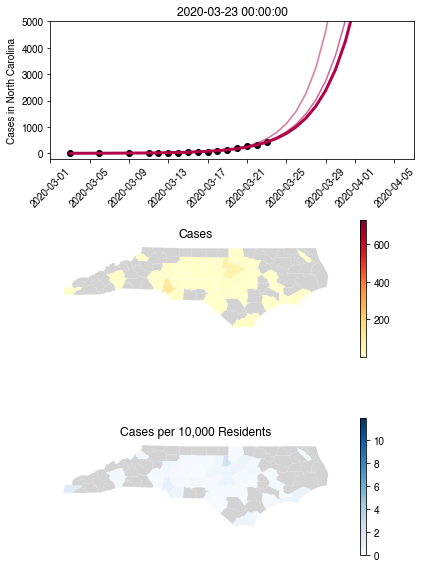

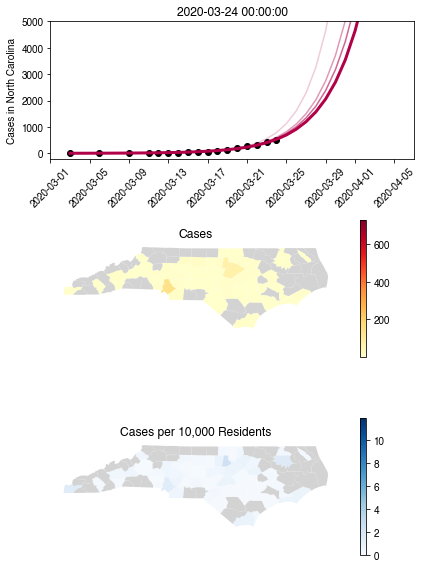

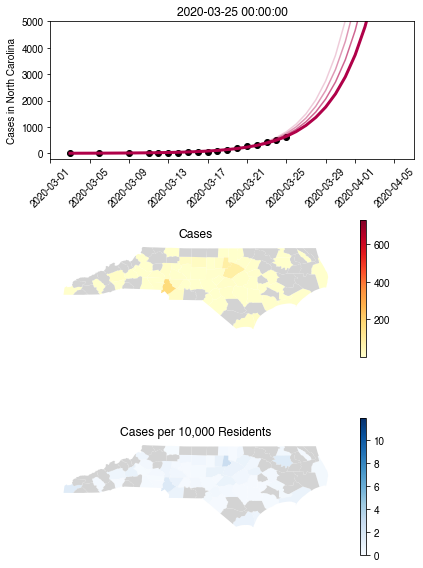

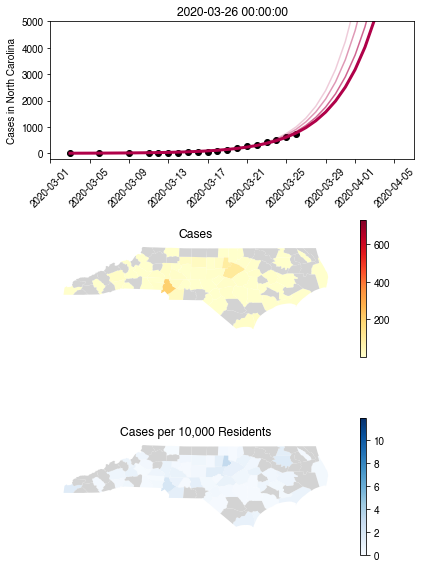

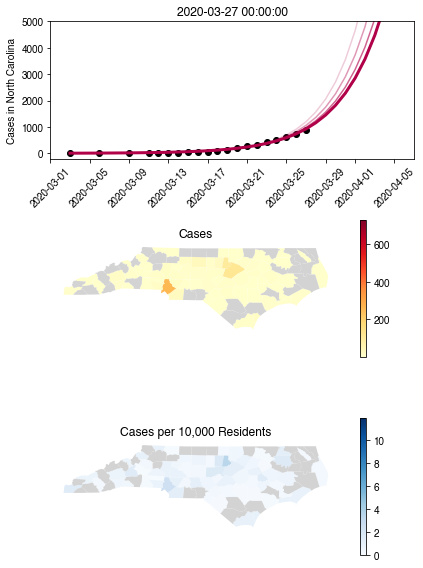

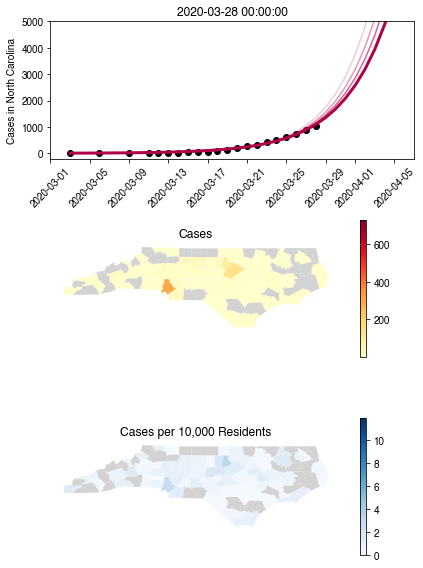

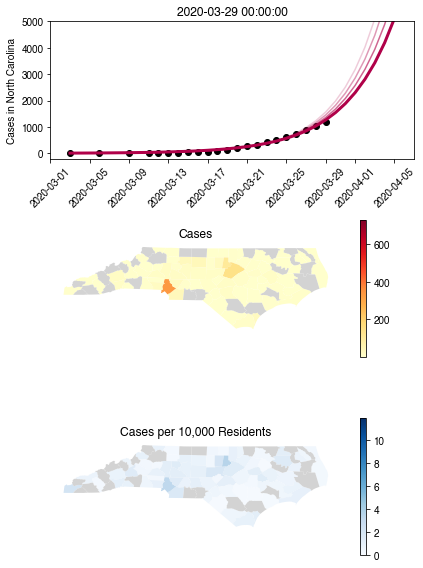

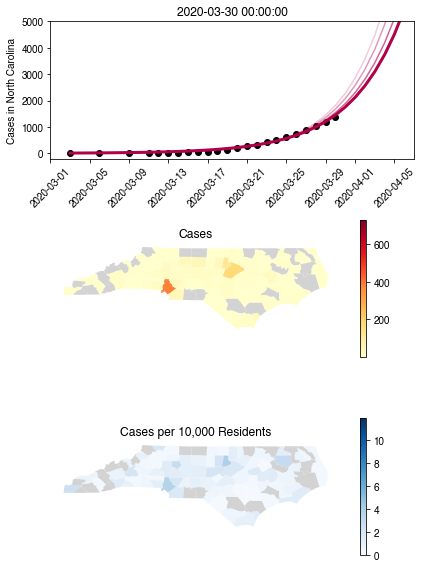

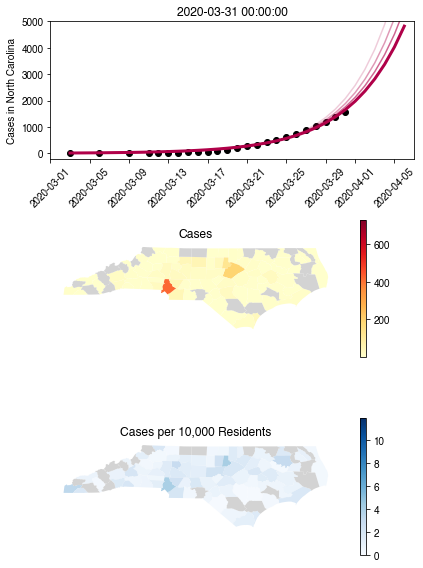

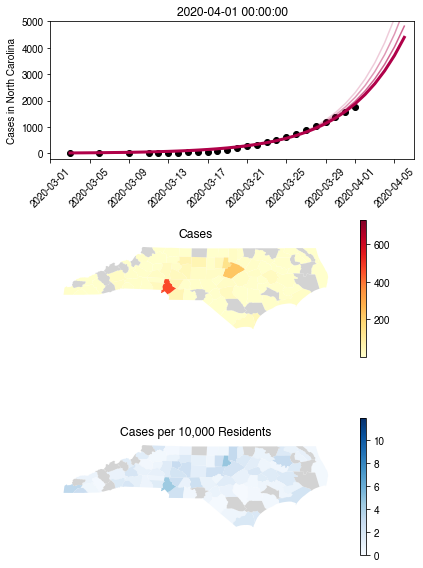

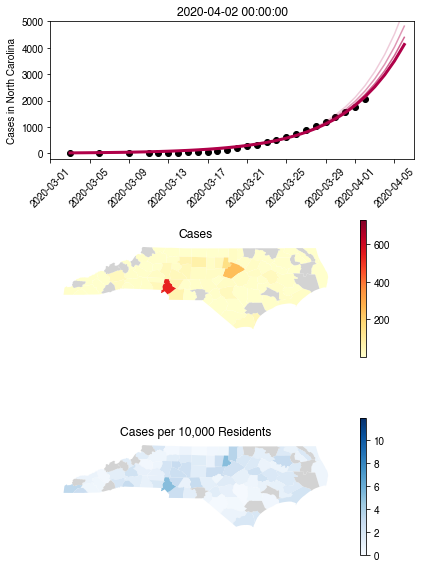

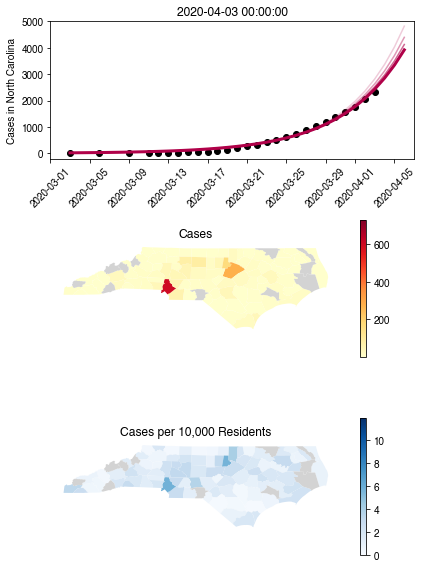

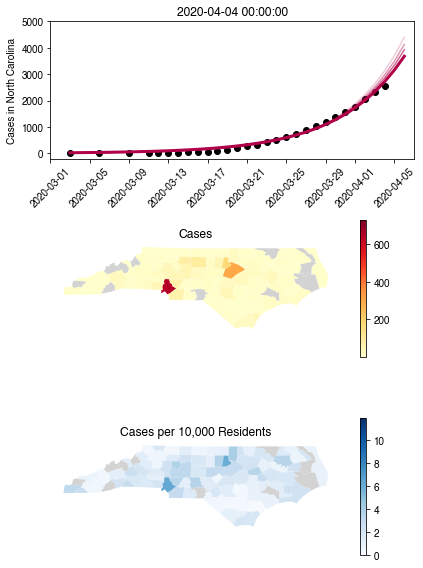

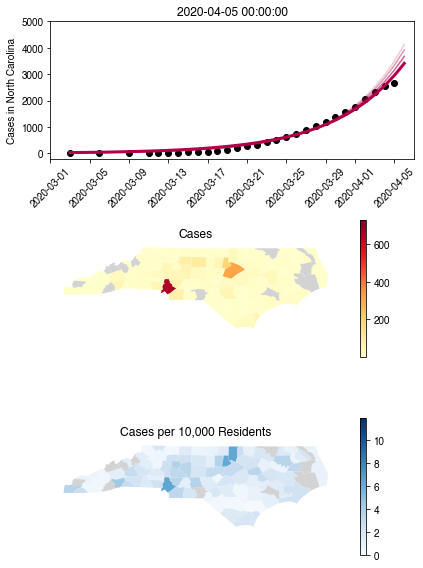

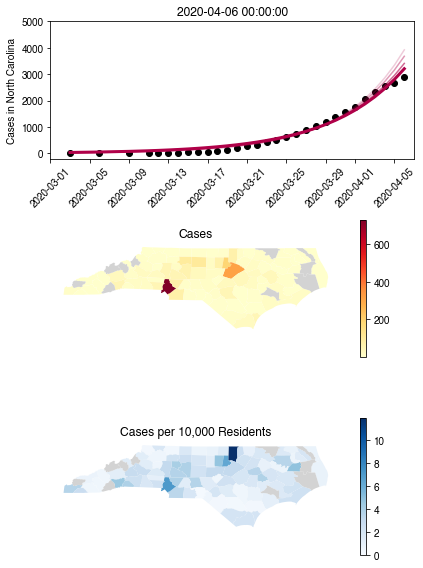

In [61]:
ndays = 34

n = 0 

datelist = pd.date_range(pd.datetime(2020,3,4), periods=ndays).tolist()

max_date = datelist[ndays-1]

cases_by_county=cases[cases['Date']<=max_date].groupby('County').sum().reset_index()
merged = map_df.set_index('Name').join(cases_by_county.set_index('County')).reset_index()
merged = merged.set_index('Name').join(demographics.set_index('Name')).reset_index()
merged['Per capita'] = merged['Cases']/merged['Population']*10000

pmin, pmax = np.nanmin(merged['Per capita']), np.nanmax(merged['Per capita'])
pmin = 0

vmin, vmax = np.nanmin(merged['Cases']), np.nanmax(merged['Cases'])
vmin = 1

def test(x, k, b): 
    return 10380000 / (1 + b*np.exp(-k*(x)))

fits = []


 # START LOOP
for i in range(ndays):
    date = datelist[i]

    cases_by_county=cases[cases['Date']<=date].groupby('County').sum().reset_index()
    merged = map_df.set_index('Name').join(cases_by_county.set_index('County')).reset_index()
    merged = merged.set_index('Name').join(demographics.set_index('Name')).reset_index()
    merged['Per capita'] = merged['Cases']/merged['Population']*10000

    fig, (ax2, ax, ax3) = plt.subplots(3,1, figsize=(6, 8));

    merged.plot(column='Cases',ax=ax,cmap='YlOrRd',vmin=vmin, vmax=vmax)
    merged[merged['Cases'].isnull()].plot(ax=ax,color='lightgray')
    
        # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = plt.colorbar(sm, ax = ax)
    
    merged.plot(column='Per capita',ax=ax3,cmap='Blues',vmin=pmin, vmax=pmax)
    merged[merged['Cases'].isnull()].plot(ax=ax3,color='lightgray')

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=pmin, vmax=pmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = plt.colorbar(sm, ax=ax3)
    
    ax.axis('off');
    ax3.axis('off');

    x = all_cases_by_date['Date'][all_cases_by_date['Date']<=date]
    y = all_cases_by_date['Cumulative'][all_cases_by_date['Date']<=date]
    
    ax2.plot(x,y,'ko') 

    x_fit = (x -  pd.datetime(2020,3,3)).astype(int)/86400000000000
    x_all = all_cases_by_date['Date']
    x_fit_all = (all_cases_by_date['Date'] -  pd.datetime(2020,3,3)).astype(int)/86400000000000


    if i > 1:
        param, param_cov = curve_fit(test, x_fit, y) 
        y_fit = test(x_fit_all,param[0],param[1])
        fits.append(y_fit)
        n += 1
        ax2.plot(x_all,y_fit,'xkcd:raspberry', alpha = 1, linewidth = 3)
    if n > 1:
        ax2.plot(x_all,fits[n-1],'xkcd:raspberry', alpha = 0.8)
    if n > 2:
        ax2.plot(x_all,fits[n-2],'xkcd:raspberry', alpha = 0.6)
    if n > 3:
        ax2.plot(x_all,fits[n-3],'xkcd:raspberry', alpha = 0.4)
    if n > 4:
        ax2.plot(x_all,fits[n-4],'xkcd:raspberry', alpha = 0.2)
    ax2.set_xlim(pd.datetime(2020,3,1),max_date+1)
    ax2.set_ylim(-200, 5000)

    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)
    
    ax2.set_title(str(date))
    
    ax2.set_ylabel('Cases in North Carolina')
    ax.set_title('Cases')
    ax3.set_title('Cases per 10,000 Residents')
    
    fig.tight_layout()
    
    fig.savefig('frame_'+str(i)+'_.png',dpi=200)


In [62]:
# sort the .png files based on index used above
images,image_file_names = [],[]
for file_name in os.listdir('./'):
    if file_name.endswith('.png'):
        image_file_names.append(file_name)       
sorted_files = sorted(image_file_names, key=lambda y: int(y.split('_')[1]))

# define some GIF parameters

frame_length = 0.5 # seconds between frames
end_pause = 4 # seconds to stay on last frame
# loop through files, join them to image array, and write to GIF called 'wind_turbine_dist.gif'
for ii in range(0,len(sorted_files)):       
    file_path = os.path.join('./', sorted_files[ii]) 
    images.append(imageio.imread(file_path))
# the duration is the time spent on each image (1/duration is frame rate)
imageio.mimsave('2020-04-06.gif', images,'GIF',duration=frame_length)